In [12]:
import io
import pandas as pd
import opensim as osim
from connections import AWS

In [5]:
""" INITIALIZE AWS CONNECTION """
aws_connection = AWS()
aws_connection.connect()

[AWS]: Port 5433 is free.
[AWS]: Connected to RDS endpoint.


$\textbf{Inverse Kinematics: Trajectory Plots \& QA}$

In [16]:
from biomech.algorithms import diff_three_point

In [3]:
# load a .mot file (e.g., results from an IK run)
def load_mot_file(path: str) -> pd.DataFrame:
    return pd.read_csv(path, delim_whitespace=True, skiprows=10)

In [ ]:
# load all IK results files
s3_objects = aws_connection.list_s3_objects(prefix='biomechanics/subjects/')
mot_files = [obj for obj in s3_objects if obj.endswith('.mot') and '_ik' in obj]

In [ ]:
# load a trial and convert from bytes to DF
ik_bytes = aws_connection.load_s3_object(mot_files[0])
ik_df = load_mot_file(io.BytesIO(ik_bytes))

$\textbf{Plotting}$

- Elbow flexion angle and angular velocity
- Comparison of trajectories across filtering cutoffs

In [27]:
from biomech.algorithms import butter_lowpass_filter

<Axes: >

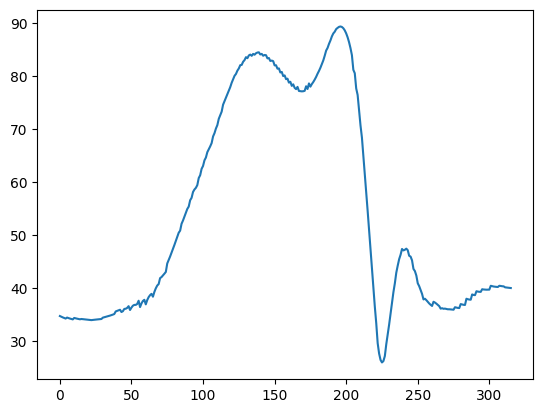

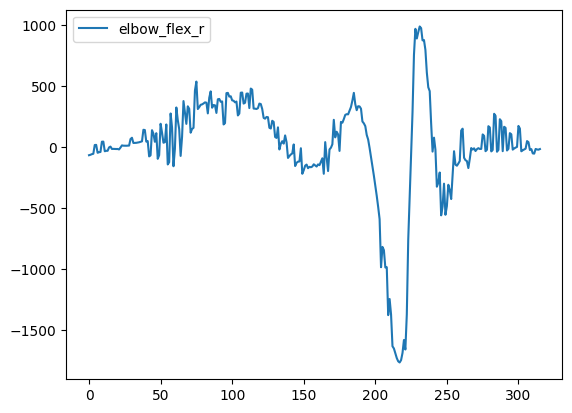

In [26]:
""" Option 1: No Filtering """
# --> consistent noise throughout pitch cycle

# plot elbow flexion angle
ik_df['elbow_flex_r'].plot()

# plot elbow flexion angular velocity
diff_elbow_flex = diff_three_point(ik_df['elbow_flex_r'].values.reshape(-1, 1))
pd.DataFrame(diff_elbow_flex, columns=['elbow_flex_r']).plot()

In [ ]:
""" Option 2: 18 Hz Butterworth Filter """
# this matches the current setup for ID
# --> much cleaner signal; might be worth manually filtering and not relying on OpenSim

<Axes: >

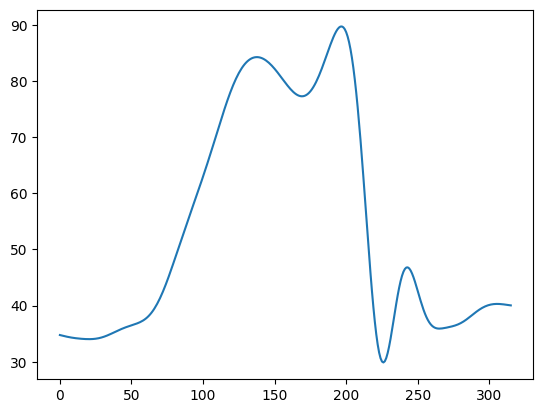

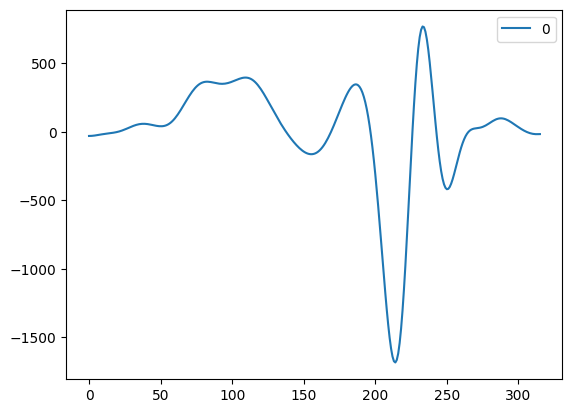

In [35]:
# apply bw filter to data
ik_df_filt_18 = ik_df.copy()
ik_df_filt_18 = butter_lowpass_filter(
    ik_df_filt_18,
    columns=[
        'arm_flex_r', 'arm_add_r', 'arm_rot_r', 
        'elbow_flex_r', 'pro_sup_r', 'wrist_flex_r', 'wrist_dev_r'
    ],
    cutoff=18,
    order=4
)

# plot elbow flexion angle
ik_df_filt_18['elbow_flex_r'].plot()

# plot elbow flexion angular velocity
diff_elbow_flex_filt_18 = diff_three_point(ik_df_filt_18['elbow_flex_r'].values.reshape(-1, 1))
pd.DataFrame(diff_elbow_flex_filt_18).plot()

In [33]:
""" Option 3: 13.4 Hz Butterworth Filter """
# this is NOT the current setup for ID, but is used in some other analyses
# --> amplitudes are reduced relative to 18 Hz

,diff_time,diff_arm_flex_r,diff_arm_add_r,diff_arm_rot_r,diff_humerus_r_tx,diff_humerus_r_ty,diff_humerus_r_tz,diff_elbow_flex_r,diff_pro_sup_r,diff_wrist_flex_r,diff_wrist_dev_r
0,1.008,18.072320,109.067929,-123.875722,0.984120,-0.324619,-0.105163,-30.750344,-0.256844,-45.356507,-24.480628
1,1.008,18.027887,108.761367,-123.411433,1.037573,-0.309362,-0.105182,-30.535841,-0.205026,-45.334223,-24.506895
2,1.008,17.822814,108.052191,-123.209407,1.096694,-0.293088,-0.103826,-29.900783,-0.086566,-45.570570,-24.692482
3,1.008,17.354239,107.174093,-124.448975,1.109978,-0.289507,-0.101028,-28.883745,0.060407,-46.350662,-25.131524
4,1.008,16.560848,106.166302,-127.068512,0.837967,-0.495605,0.092738,-27.551804,0.232577,-47.621069,-25.789731
...,...,...,...,...,...,...,...,...,...,...,...
311,1.008,-402.911895,-165.751619,508.158848,0.496980,-0.886313,-0.838982,-16.737639,-59.169649,-40.532925,38.550460
312,1.008,-375.898624,-156.773075,485.278749,0.680664,-0.958546,-0.882955,-17.574356,-57.988513,-40.655950,39.528095
313,1.008,-346.786233,-146.270113,456.760358,0.361382,-0.789194,-0.764518,-17.776802,-55.816083,-39.796353,39.356843
314,1.008,-315.791768,-134.410961,423.060119,0.320090,-0.742627,-0.728412,-17.398993,-52.706751,-38.036168,38.120318


<Axes: >

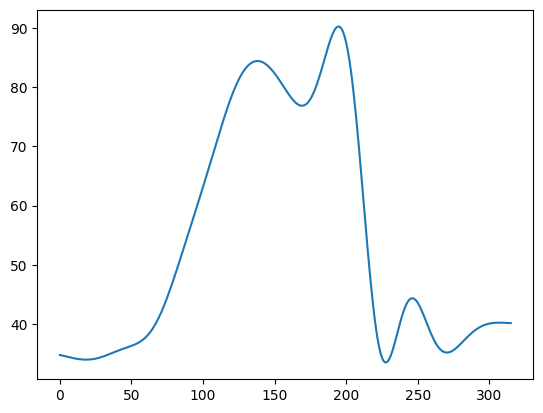

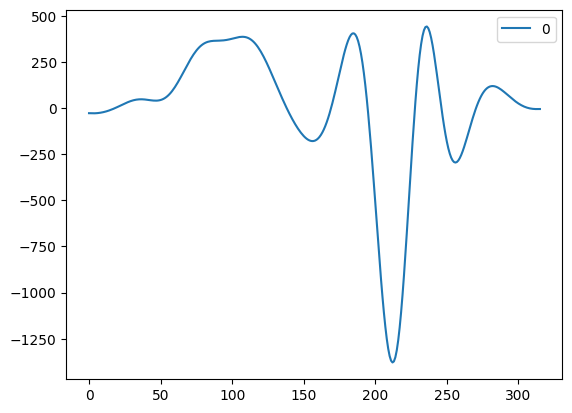

In [36]:
# apply bw filter to data
ik_df_filt_13 = ik_df.copy()
ik_df_filt_13 = butter_lowpass_filter(
    ik_df_filt_13,
    columns=[
        'arm_flex_r', 'arm_add_r', 'arm_rot_r', 
        'elbow_flex_r', 'pro_sup_r', 'wrist_flex_r', 'wrist_dev_r'
    ],
    cutoff=13,
    order=4
)

# plot elbow flexion angle
ik_df_filt_13['elbow_flex_r'].plot()

# plot elbow flexion angular velocity
diff_elbow_flex_filt_13 = diff_three_point(ik_df_filt_13['elbow_flex_r'].values.reshape(-1, 1))
pd.DataFrame(diff_elbow_flex_filt_13).plot()

$\textbf{Write to .mot File}$

For compatibility with OpenSim tools.

In [40]:
header = [
    "Coordinates",
    "version=1",
    f"nRows={ik_df_filt_18.shape[0]}",
    "nColumns=11",
    "inDegrees=yes",
    "",
    "Units are S.I. units (second, meters, Newtons, ...)",
    "If the header above contains a line with 'inDegrees', this indicates whether rotational values are in degrees (yes) or radians (no).",
    "",
    "endheader"
]

with open("test_motion.mot", "w") as f:
    for line in header:
        f.write(line + "\n")
    # Write column headers
    f.write('\t'.join(ik_df_filt_18.columns) + '\n')
    # Write data rows with required spacing
    for row in ik_df_filt_18.itertuples(index=False):
        row_str = f"{' '*6}{row[0]:.4f}"
        for val in row[1:]:
            row_str += f"\t{' '*6}{val:.6f}"
        f.write(row_str + "\n")

$\textbf{Close AWS Connection}$

In [41]:
aws_connection.close()

[AWS]: Database connection closed.
[AWS]: SSH tunnel stopped.
